In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import warnings

from yellowbrick.classifier import ClassificationReport

In [3]:
cohort_79 = pd.read_csv('data/cohort79_Jun8.csv')

In [4]:
cohort_97 = pd.read_csv('data/cohort97_Jun8.csv')

In [5]:
merged_data = pd.concat([cohort_79, cohort_97], sort=False)
merged_data.drop(merged_data[merged_data["adjusted_income"] <= 1000].index, inplace=True)
merged_data.fillna(0, inplace=True)

predictors = list(merged_data.columns)
vars_to_drop = ["case_id","urban_or_rural","family_size", "sample_id", "year", "shock", "region", "highest_grade", "industry", "occupation", "Unnamed: 0",'marital_status', 'race']
for var in vars_to_drop:
    predictors.remove(var)
    
X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data["shock"], test_size = 0.2)

In [6]:
dummy_predictions = np.full((len(X_test), 1), merged_data["shock"].median())
dummy_probs = np.full((len(X_test), 1), merged_data["shock"].mean())
dummy_report = classification_report(y_test, dummy_predictions, target_names=["No shock","Shock"])
print(dummy_report)

brier_skill_ref = brier_score_loss(y_test, dummy_probs)
print("Brier score (lower is better): {:.03f}.".format(brier_skill_ref))

              precision    recall  f1-score   support

    No shock       0.76      1.00      0.86     27369
       Shock       0.00      0.00      0.00      8652

   micro avg       0.76      0.76      0.76     36021
   macro avg       0.38      0.50      0.43     36021
weighted avg       0.58      0.76      0.66     36021

Brier score (lower is better): 0.183.


/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    # The standard scaler will raise a warning about variable types. To suppress those for the moment...    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    estimator.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)
    predicted_proba = estimator.predict_proba(X_test)[:,1]
    
    score_report = classification_report(expected, predicted, target_names=["No shock","Shock"])
    print("Model: {}\n".format(estimator.__class__.__name__))
    print(score_report)
    print("Brier score (lower is better): {:.03f}\n\n".format(brier_score_loss(y_test, predicted_proba)))
    

In [8]:
import time

start_time = time.time()

In [9]:
X = merged_data[predictors]
y = np.ravel(merged_data["shock"])

# Try them all!

models = [
    SGDClassifier(loss="log", max_iter=1000, tol=.001),
    LogisticRegression(solver="lbfgs"),
    MLPClassifier(hidden_layer_sizes=(75,), learning_rate="adaptive", alpha=.001, solver="sgd", activation="tanh", max_iter=500),
    GradientBoostingClassifier(n_estimators=100, learning_rate=.3, min_samples_leaf=25, max_depth=4),
    RandomForestClassifier(n_estimators=100),
    BaggingClassifier(),
    GaussianNB(),
    ExtraTreesClassifier(),
]

for model in models:
    score_model(X, y, model)

Model: SGDClassifier

              precision    recall  f1-score   support

    No shock       0.78      0.97      0.86     27574
       Shock       0.49      0.09      0.15      8447

   micro avg       0.76      0.76      0.76     36021
   macro avg       0.64      0.53      0.50     36021
weighted avg       0.71      0.76      0.70     36021

Brier score (lower is better): 0.171


Model: LogisticRegression

              precision    recall  f1-score   support

    No shock       0.77      0.98      0.86     27419
       Shock       0.55      0.07      0.13      8602

   micro avg       0.76      0.76      0.76     36021
   macro avg       0.66      0.53      0.50     36021
weighted avg       0.72      0.76      0.69     36021

Brier score (lower is better): 0.170


Model: MLPClassifier

              precision    recall  f1-score   support

    No shock       0.78      0.96      0.86     27411
       Shock       0.55      0.16      0.24      8610

   micro avg       0.77      0.77

/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model: ExtraTreesClassifier

              precision    recall  f1-score   support

    No shock       0.78      0.94      0.85     27465
       Shock       0.42      0.14      0.21      8556

   micro avg       0.75      0.75      0.75     36021
   macro avg       0.60      0.54      0.53     36021
weighted avg       0.69      0.75      0.70     36021

Brier score (lower is better): 0.185




In [10]:
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:04:32'

The model that performed the best using was Gradient Boosting Classifier with a Brier score of: 0.162 

# Cross Validation Visualization for Classification Model

In [11]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
import matplotlib.pyplot as plt


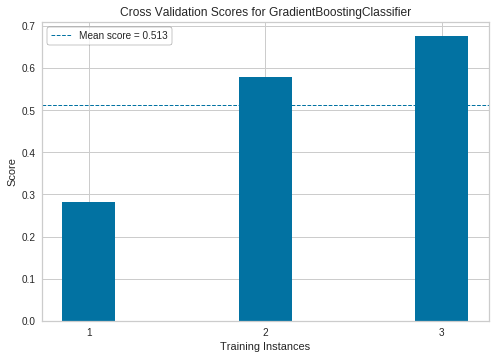

In [12]:
# Create a new figure and axes
_, ax = plt.subplots()

# Create a cross-validation strategy
cv = StratifiedKFold(3)

# Create the cv score visualizer
oz = CVScores(
    GradientBoostingClassifier(n_estimators=100, learning_rate=.3, min_samples_leaf=25, max_depth=4), ax=ax, cv=cv, scoring='f1_weighted',
    #MLPClassifier(hidden_layer_sizes=(75,), learning_rate="adaptive", alpha=.001, solver="sgd", activation="tanh", max_iter=500),

)

oz.fit(X, y)
oz.poof()


/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


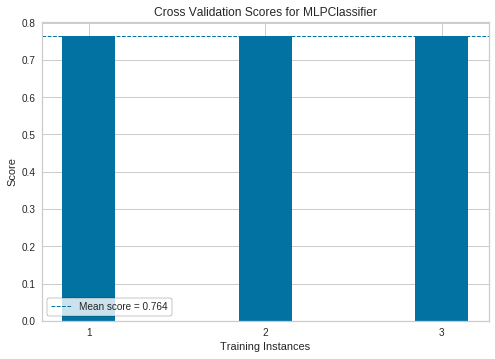

In [13]:
# Create a new figure and axes
_, ax = plt.subplots()

# Create a cross-validation strategy
cv = StratifiedKFold(2)

# Create the cv score visualizer
oz = CVScores(
    #GradientBoostingClassifier(), ax=ax, cv=cv, scoring='f1_weighted',
    MLPClassifier(hidden_layer_sizes=(75,), learning_rate="adaptive", alpha=.001, solver="sgd", activation="tanh", max_iter=500),

)

oz.fit(X, y)
oz.poof()


# Model Selection Visualizer for Classification

## Learning Curve

In [14]:
from yellowbrick.model_selection import LearningCurve

/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


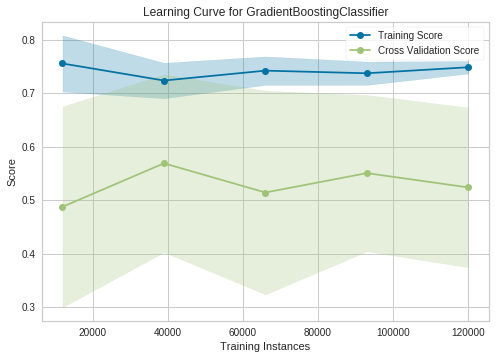

In [15]:

viz = LearningCurve(
    GradientBoostingClassifier(n_estimators=100, learning_rate=.3, min_samples_leaf=25, max_depth=4),
    scoring='f1_weighted', n_jobs=2
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


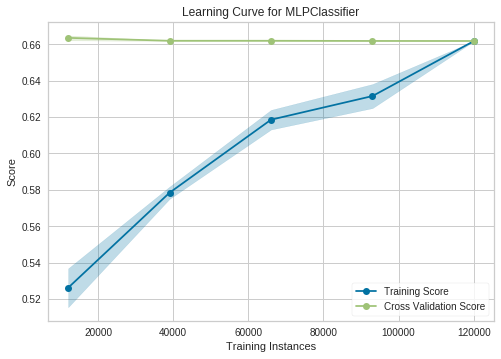

In [16]:

viz = LearningCurve(
    MLPClassifier(hidden_layer_sizes=(75,), learning_rate="adaptive", alpha=.001, solver="sgd", activation="tanh"),
    scoring='f1_weighted', n_jobs=2
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

In [17]:
print(X.columns)

Index(['sex', 'adjusted_income', 'age', 'curr_pregnant', 'work_kind_limited',
       'work_amount_limited', 'hours_worked_last_year',
       'weeks_worked_last_year', 'number_of_kids', 'prior_income',
       'unemployment', 'gdp_growth', 'inflation', 'regional_unemployment',
       'income_change', 'work_limited', 'region_1', 'region_2', 'region_3',
       'region_4', 'highest_grade_0', 'highest_grade_5', 'highest_grade_8',
       'highest_grade_12', 'highest_grade_13', 'highest_grade_16',
       'highest_grade_17', 'industry_10', 'industry_40', 'industry_60',
       'industry_100', 'industry_400', 'industry_500', 'industry_580',
       'industry_700', 'industry_721', 'industry_761', 'industry_800',
       'industry_812', 'industry_900', 'industry_940', 'industry_992',
       'occupation_10', 'occupation_500', 'occupation_800', 'occupation_1000',
       'occupation_1300', 'occupation_1550', 'occupation_1600',
       'occupation_2000', 'occupation_2100', 'occupation_2200',
       'occup